In [1]:
import os
import subprocess
import h5py
import matplotlib.pyplot as plt
import string
import numpy as np
from glob import glob
from skimage.io import imread
from skimage.transform import downscale_local_mean
import pandas as pd
import seaborn as sns
from pywavesurfer import ws
from scipy.io import savemat,loadmat
import numpy as np
# From Process H5 file (duplicate modules deleted)
from pywavesurfer import ws

- Filter data for ploting (date, curated well, dye, etc)

In [2]:
# df_fix = pd.read_pickle(sumPath+'/combo mutants/20230327_wHaloCaMP_raw/wHaloCaMP_combo_screening_red_ref_20230327_wHaloCaMP_raw.pkl')

In [3]:
# df_fix[df_fix['Construct_ID'].str.contains('139.18787')]
# df_fix = df_fix.replace('139.18787','139.1787')

In [4]:
# df_fix.to_pickle(sumPath+'/combo mutants/20230327_wHaloCaMP_raw/wHaloCaMP_combo_screening_red_ref_20230327_wHaloCaMP_raw.pkl')

In [6]:
# savePath = '/Volumes/genie/Presentations/Jihong/GENIE production/230425/wHaloCaMP screening'
# if not os.path.exists(savePath):
#     os.makedirs(savePath)

sumPath = '/Volumes/genie/Jihong_GENIE_stuff/GECI_screening/wHaloCaMP'

dates = ['20230306_wHaloCaMP_raw','20230313_wHaloCaMP_raw','20230320_wHaloCaMP_raw','20230327_wHaloCaMP_raw',
         '20230403_wHaloCaMP_raw','20230410_wHaloCaMP_raw','20230417_wHaloCaMP_raw','20230424_wHaloCaMP_raw',
        '20230501_wHaloCaMP_raw','20230508_wHaloCaMP_raw','20230515_wHaloCaMP_raw','20230522_wHaloCaMP_raw']

# dates = ['20230424_wHaloCaMP_raw']

df_2023 = pd.DataFrame()
for date in dates:
    data = glob(os.path.join(sumPath,'combo & single mutants 2023',date)+'/*.pkl')[0]
    df_temp = pd.read_pickle(data)
    df_2023 = pd.concat([df_2023,df_temp],axis=0)
print(df_2023.shape)

data = glob(os.path.join(sumPath,'single mutants only')+'/*.pkl')[0]
df_2022 = pd.read_pickle(data)
df_2022.shape

(26688, 20)


(72596, 20)

In [9]:
df_2023.columns

Index(['Date', 'Plate', 'Well', 'Construct', 'Construct_ID', 'Stim', 'DFF',
       'F0', 'dFF_peak', 'T_peak', 'Half_rise', 'Half_decay', 'ImageTime',
       'VPulseTime', 'nVPulse', 'Dye', 'Filter',
       'Power at specimen level (mW)', 'Controller intensity setting',
       'Curated'],
      dtype='object')

In [10]:
df_2023['Construct'].unique().shape
# df_2023 = df_2023.dropna()
# # C = ['139.1832','139.1760','139.1843','139.1842','139.1766','139.1756','139.1784','139.1831']
# C = ['139.1873','139.553']
# for c in C:
#     print(c,df_2023[df_2023['Construct_ID']==c].Plate.unique().shape)
# #     print(c,df_2022[df_2022['Construct_ID']==c].Plate.unique().shape)

(1284,)

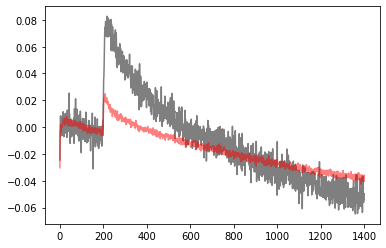

In [13]:
df_p = df_2023[(df_2023['Construct_ID']=='139.1832')&(df_2023['Stim']=='001FP')]
Mean = []
for i,r in df_p.iterrows():
    Mean.append(r['DFF'])
plt.plot(np.nanmean(Mean,axis=0),color='k',alpha=0.5)

df_c = df_2023[(df_2023['Plate'].isin(df_p['Plate'].unique()))&(df_2023['Construct_ID']=='139.1')&(df_2023['Stim']=='001FP')]

Mean = []
for i,r in df_c.iterrows():
    Mean.append(r['DFF'])
plt.plot(np.nanmean(Mean,axis=0),color='r',alpha=0.5)

In [26]:
df = df_2023
df = df[df['Construct']!='TEOnly']
C_for_sorting = []
for i,r in df.iterrows():
    if len(r['Construct'])==10:
        C_for_sorting.append(r['Construct'])
    elif len(r['Construct'])==9:
        C_for_sorting.append(r['Construct'][:6]+'0'+r['Construct'][6:])
    elif len(r['Construct'])==7:
        C_for_sorting.append(r['Construct'][:6]+'000'+r['Construct'][6:])
    else:
        print(r['Construct'])
        C_for_sorting.append('139dot1878')

In [27]:
df = df.assign(Construct_for_sorting = C_for_sorting)

In [28]:
df = df.sort_values(by='Construct_for_sorting',ascending=True)
df.shape

(26624, 21)

In [35]:
df = df.dropna()
df.index = np.arange(len(df))

In [40]:
# df.Construct.unique().shape
# df.Construct.unique()
# df[df['Construct']=='139dot']
# df_combo = df.loc[1736:7196,:]
df_combo = df.loc[1784:7083,:]
# df[df['Construct']=='139dot1728'] # 1st combo
# df[df['Construct']=='139dot1854'] # last combo 

In [ ]:
# df = df[df['Construct'].str.contains('141')]

In [ ]:
df_parents = pd.read_excel(sumPath+'/139-1_parents_for_Combos.xlsx')

In [ ]:
# df_parents

In [ ]:
df_parents = df[df['Construct'].isin(df_parents['ID'].unique())]
# df_parents

In [ ]:
df_single = df[(~df['Construct'].isin(df_combo['Construct'].unique()))&(~df['Construct'].isin(df_parents['Construct'].unique()))]
# df_single

In [ ]:
# df_single['Construct'].unique()

#### Kerr plot (unnormalized data)

In [41]:
stim = '001FP'
# Seperate control (139.1) and other variants to plot control with different marker (x)
# df_ctr = df[(df['Curated']=='False')&(df['Stim']==stim)&(df['Construct']=='139dot1')]
# df_sel = df[(df['Curated']=='False')&(df['Stim']==stim)&(df['Construct']!='139dot1')]

In [45]:
df_plot_mean_combo = pd.DataFrame()
# df_plot_mean_control = pd.DataFrame()

Construct = []
mean_dFF = []
mean_F0 = []
mean_Rise = []
mean_Decay = []

sem_dFF = []
sem_F0 = []
sem_Rise = []
sem_Decay = []

for c in df_combo['Construct'].unique():
    df_temp = df_combo[(df_combo['Construct']==c)&(df_combo['Stim']==stim)]
    mean_dff = df_temp.dFF_peak.mean()*100
    mean_f0 = df_temp.F0.mean()
    mean_rise = df_temp.Half_rise.mean()
    mean_decay = df_temp.Half_decay.mean()
    
    sem_dff = df_temp.dFF_peak.sem()*100
    sem_f0 = df_temp.F0.sem()
    sem_rise = df_temp.Half_rise.sem()
    sem_decay = df_temp.Half_decay.sem()
    
    Construct.append(c)    
    mean_dFF.append(mean_dff)
    mean_F0.append(mean_f0)
    mean_Rise.append(mean_rise)
    mean_Decay.append(mean_decay)

    sem_dFF.append(sem_dff)
    sem_F0.append(sem_f0)
    sem_Rise.append(sem_rise)
    sem_Decay.append(sem_decay)
    
df_plot_mean_combo['Construct'] = Construct
df_plot_mean_combo['Peak \u0394F/F0'] = mean_dFF
df_plot_mean_combo['F0'] = mean_F0
df_plot_mean_combo['Half rise time (s)'] = mean_Rise
df_plot_mean_combo['Half decay time (s)'] = mean_Decay

df_plot_mean_combo['Peak \u0394F/F0 sem'] = sem_dFF
df_plot_mean_combo['F0 sem'] = sem_F0
df_plot_mean_combo['Half rise time (s) sem'] = sem_Rise
df_plot_mean_combo['Half decay time (s) sem'] = sem_Decay

In [43]:
df_plot_mean_parents = pd.DataFrame()
# df_plot_mean_control = pd.DataFrame()

Construct = []
mean_dFF = []
mean_F0 = []
mean_Rise = []
mean_Decay = []

sem_dFF = []
sem_F0 = []
sem_Rise = []
sem_Decay = []

for c in df_parents['Construct'].unique():
    df_temp = df_parents[(df_parents['Construct']==c)&(df_parents['Stim']==stim)]
    mean_dff = df_temp.dFF_peak.mean()*100
    mean_f0 = df_temp.F0.mean()
    mean_rise = df_temp.Half_rise.mean()
    mean_decay = df_temp.Half_decay.mean()
    
    sem_dff = df_temp.dFF_peak.sem()*100
    sem_f0 = df_temp.F0.sem()
    sem_rise = df_temp.Half_rise.sem()
    sem_decay = df_temp.Half_decay.sem()
    
    Construct.append(c)    
    mean_dFF.append(mean_dff)
    mean_F0.append(mean_f0)
    mean_Rise.append(mean_rise)
    mean_Decay.append(mean_decay)

    sem_dFF.append(sem_dff)
    sem_F0.append(sem_f0)
    sem_Rise.append(sem_rise)
    sem_Decay.append(sem_decay)
    
df_plot_mean_parents['Construct'] = Construct
df_plot_mean_parents['Peak \u0394F/F0'] = mean_dFF
df_plot_mean_parents['F0'] = mean_F0
df_plot_mean_parents['Half rise time (s)'] = mean_Rise
df_plot_mean_parents['Half decay time (s)'] = mean_Decay

df_plot_mean_parents['Peak \u0394F/F0 sem'] = sem_dFF
df_plot_mean_parents['F0 sem'] = sem_F0
df_plot_mean_parents['Half rise time (s) sem'] = sem_Rise
df_plot_mean_parents['Half decay time (s) sem'] = sem_Decay

NameError: name 'df_parents' is not defined

In [44]:
df_plot_mean_single = pd.DataFrame()

Construct = []
mean_dFF = []
mean_F0 = []
mean_Rise = []
mean_Decay = []

sem_dFF = []
sem_F0 = []
sem_Rise = []
sem_Decay = []

for c in df_single['Construct'].unique():
    df_temp = df_single[(df_single['Construct']==c)&(df_single['Stim']==stim)]
    mean_dff = df_temp.dFF_peak.mean()*100
    mean_f0 = df_temp.F0.mean()
    mean_rise = df_temp.Half_rise.mean()
    mean_decay = df_temp.Half_decay.mean()
    
    sem_dff = df_temp.dFF_peak.sem()*100
    sem_f0 = df_temp.F0.sem()
    sem_rise = df_temp.Half_rise.sem()
    sem_decay = df_temp.Half_decay.sem()
    
    Construct.append(c)    
    mean_dFF.append(mean_dff)
    mean_F0.append(mean_f0)
    mean_Rise.append(mean_rise)
    mean_Decay.append(mean_decay)

    sem_dFF.append(sem_dff)
    sem_F0.append(sem_f0)
    sem_Rise.append(sem_rise)
    sem_Decay.append(sem_decay)
    
df_plot_mean_single['Construct'] = Construct
df_plot_mean_single['Peak \u0394F/F0'] = mean_dFF
df_plot_mean_single['F0'] = mean_F0
df_plot_mean_single['Half rise time (s)'] = mean_Rise
df_plot_mean_single['Half decay time (s)'] = mean_Decay

df_plot_mean_single['Peak \u0394F/F0 sem'] = sem_dFF
df_plot_mean_single['F0 sem'] = sem_F0
df_plot_mean_single['Half rise time (s) sem'] = sem_Rise
df_plot_mean_single['Half decay time (s) sem'] = sem_Decay

NameError: name 'df_single' is not defined

In [ ]:
df_plot_mean_single = pd.DataFrame()

Construct = []
mean_dFF = []
mean_F0 = []
mean_Rise = []
mean_Decay = []

sem_dFF = []
sem_F0 = []
sem_Rise = []
sem_Decay = []
df_single = df
for c in df_single['Construct'].unique():
    df_temp = df_single[(df_single['Construct']==c)&(df_single['Stim']==stim)]
    mean_dff = df_temp.dFF_peak.mean()*100
    mean_f0 = df_temp.F0.mean()
    mean_rise = df_temp.Half_rise.mean()
    mean_decay = df_temp.Half_decay.mean()
    
    sem_dff = df_temp.dFF_peak.sem()*100
    sem_f0 = df_temp.F0.sem()
    sem_rise = df_temp.Half_rise.sem()
    sem_decay = df_temp.Half_decay.sem()
    
    Construct.append(c)    
    mean_dFF.append(mean_dff)
    mean_F0.append(mean_f0)
    mean_Rise.append(mean_rise)
    mean_Decay.append(mean_decay)

    sem_dFF.append(sem_dff)
    sem_F0.append(sem_f0)
    sem_Rise.append(sem_rise)
    sem_Decay.append(sem_decay)
    
df_plot_mean_single['Construct'] = Construct
df_plot_mean_single['Peak \u0394F/F0'] = mean_dFF
df_plot_mean_single['F0'] = mean_F0
df_plot_mean_single['Half rise time (s)'] = mean_Rise
df_plot_mean_single['Half decay time (s)'] = mean_Decay

df_plot_mean_single['Peak \u0394F/F0 sem'] = sem_dFF
df_plot_mean_single['F0 sem'] = sem_F0
df_plot_mean_single['Half rise time (s) sem'] = sem_Rise
df_plot_mean_single['Half decay time (s) sem'] = sem_Decay

In [ ]:
import matplotlib
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[10.5,7])
plt.rc('font', size=13)
ax = plt.subplot(111)

a = np.quantile(df_plot_mean_single['Half rise time (s)'],0.1)
b = np.quantile(df_plot_mean_single['Half rise time (s)'],0.85)
c_map = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(a,b)

scale = 50/np.quantile(df_plot_mean_single['Half decay time (s)'],0.5)


single = plt.scatter(df_plot_mean_single['Peak \u0394F/F0'],df_plot_mean_single['F0'],
                                 c=df_plot_mean_single['Half rise time (s)'],
                                 s=df_plot_mean_single['Half decay time (s)']*scale,cmap="jet")


plt.legend(*single.legend_elements("sizes",num=5,func=lambda x: x/scale),title='Half decay time (s)',
           loc='upper right')

# plt.errorbar(df_ctr.dFF_peak.mean()*100,df_ctr.F0.mean(),xerr=df_ctr.dFF_peak.sem()*100,
#             yerr=df_ctr.F0.sem(),fmt='o', markersize=0,c=c_map(norm(df_ctr.Half_rise.mean())))
# plt.errorbar(df_plot_mean['Peak \u0394F/F0'],df_plot_mean['F0'],xerr=df_plot_mean['Peak \u0394F/F0 sem'],
#              yerr=df_plot_mean['F0 sem'],fmt='o', markersize=0,c=c_map(norm(df_plot_mean['Half rise time (s)'])))
# plt.errorbar(df_plot_mean_single['Peak \u0394F/F0'],df_plot_mean_single['F0'],
#              xerr=df_plot_mean_single['Peak \u0394F/F0 sem'],
#              yerr=df_plot_mean_single['F0 sem'],fmt='o',markersize=0,
#              c=c_map(norm(df_plot_mean_single['Half rise time (s)'])))

text_height = (ax.get_ylim()[1]-ax.get_ylim()[0])/40

construct_l = df_plot_mean_single.Construct.to_list()
F0_l = df_plot_mean_single['F0'].to_list()
dFF_l = df_plot_mean_single['Peak \u0394F/F0'].to_list()
top_hits = []
for i,construct in enumerate(construct_l):
    if construct=='141dot1':
        ax.text(dFF_l[i],F0_l[i]+text_height,"%s" %construct.replace('dot','.'),ha="center",size=14)
#     if dFF_l[i]>20: # 001FP
#     if dFF_l[i]>25: # 003FP
#     if dFF_l[i]>40: # 010FP
    if dFF_l[i]>80: # 160FP
        ax.text(dFF_l[i],F0_l[i]+text_height,"%s" %construct.replace('dot','.'),ha="center",size=12)
        top_hits.append(construct.replace('dot','.'))
#         top_hits.append(construct)
            
# # ax.set_xlim(0.824280347480946, 16.532403360787136)
plt.clim(a,b)
cbar = plt.colorbar(aspect=50)
cbar.ax.set_ylabel('Half rise time (s)', rotation=90,size=13)
plt.xlabel('\u0394F/F0 (%) - '+stim,size=14)
plt.ylabel('F0',size=14)
plt.tick_params(labelsize=13)
plt.tight_layout()
plt.savefig('/Users/zhengj10/Desktop/Kerr_%s.svg' %stim,format='svg')
plt.show()

In [ ]:
import matplotlib
sns.set_style(style='whitegrid')
fig = plt.figure(figsize=[10.5,7])
plt.rc('font', size=13)
ax = plt.subplot(111)

a = np.quantile(df_plot_mean_combo['Half rise time (s)'],0.1)
b = np.quantile(df_plot_mean_combo['Half rise time (s)'],0.85)
c_map = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(a,b)

scale = 50/np.quantile(df_plot_mean_combo['Half decay time (s)'],0.5)

combo = plt.scatter(df_plot_mean_combo['Peak \u0394F/F0'],df_plot_mean_combo['F0'],
                          facecolor='none',
                          edgecolor=c_map(norm(df_plot_mean_combo['Half rise time (s)'])),cmap="jet",
                          s=df_plot_mean_combo['Half decay time (s)']*scale)

single = plt.scatter(df_plot_mean_single['Peak \u0394F/F0'],df_plot_mean_single['F0'],
                                 c=df_plot_mean_single['Half rise time (s)'],
                                 s=df_plot_mean_single['Half decay time (s)']*scale,cmap="jet",marker='x')

parents = plt.scatter(df_plot_mean_parents['Peak \u0394F/F0'],df_plot_mean_parents['F0'],
                                 c=df_plot_mean_parents['Half rise time (s)'],
                                 s=df_plot_mean_parents['Half decay time (s)']*scale,cmap="jet",marker=',')

plt.legend(*combo.legend_elements("sizes",num=5,func=lambda x: x/scale),title='Half decay time (s)',
           loc='upper right')

# plt.errorbar(df_ctr.dFF_peak.mean()*100,df_ctr.F0.mean(),xerr=df_ctr.dFF_peak.sem()*100,
#             yerr=df_ctr.F0.sem(),fmt='o', markersize=0,c=c_map(norm(df_ctr.Half_rise.mean())))
# plt.errorbar(df_plot_mean['Peak \u0394F/F0'],df_plot_mean['F0'],xerr=df_plot_mean['Peak \u0394F/F0 sem'],
#              yerr=df_plot_mean['F0 sem'],fmt='o', markersize=0,c=c_map(norm(df_plot_mean['Half rise time (s)'])))
# plt.errorbar(df_plot_mean_single['Peak \u0394F/F0'],df_plot_mean_single['F0'],
#              xerr=df_plot_mean_single['Peak \u0394F/F0 sem'],
#              yerr=df_plot_mean_single['F0 sem'],fmt='o',markersize=0,
#              c=c_map(norm(df_plot_mean_single['Half rise time (s)'])))

text_height = (ax.get_ylim()[1]-ax.get_ylim()[0])/40
df_all = pd.concat([df_plot_mean_single,df_plot_mean_combo],axis=0)
construct_l = df_all.Construct.to_list()
F0_l = df_all['F0'].to_list()
dFF_l = df_all['Peak \u0394F/F0'].to_list()
top_hits = []
for i,construct in enumerate(construct_l):
    if construct=='139dot1':
        ax.text(dFF_l[i],F0_l[i]+text_height,"%s" %construct.replace('dot','.'),ha="center",size=14)
#     if dFF_l[i]>20: # 001FP
#     if dFF_l[i]>25: # 003FP
#     if dFF_l[i]>50: # 010FP
    if dFF_l[i]>150: # 160FP
        ax.text(dFF_l[i],F0_l[i]+text_height,"%s" %construct.replace('dot','.'),ha="center",size=12)
        top_hits.append(construct.replace('dot','.'))
#         top_hits.append(construct)
            
# # ax.set_xlim(0.824280347480946, 16.532403360787136)
plt.clim(a,b)
cbar = plt.colorbar(aspect=50)
cbar.ax.set_ylabel('Half rise time (s)', rotation=90,size=13)
plt.xlabel('\u0394F/F0 (%) - '+stim,size=14)
plt.ylabel('F0',size=14)
plt.tick_params(labelsize=13)
plt.tight_layout()
# plt.savefig('/Users/zhengj10/Desktop/wHaloCaMP screening/Kerr_%s.svg' %stim,format='svg')
plt.show()

In [ ]:
savePath

- Check variability of control

In [ ]:
import matplotlib

In [ ]:
stim='001FP'

sns.set_style(style='whitegrid')
scale = 100 # 001FP
# scale = 75 # 003FP
# scale = 50 # 010FP
# scale = 30 # 160FP

fig = plt.figure(figsize=(10,8))
plt.rc('font', size=13)
ax = plt.subplot(111)

df_ctr_1 = df_2022[(df_2022['Construct_ID']=='139.1')&(df_2022['Stim']==stim)]
df_ctr_2 = df_2023[(df_2023['Construct_ID']=='139.1')&(df_2023['Stim']==stim)]

df_ctr_1 = df_ctr_1.dropna()
df_ctr_2 = df_ctr_2.dropna()

a = np.quantile(df_ctr_1['Half_rise'],0.1)
b = np.quantile(df_ctr_1['Half_rise'],0.85)
c_map = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(a,b)

scale = 50/np.quantile(df_ctr_1['Half_decay'],0.5)

ctr_1 = plt.scatter(df_ctr_1.dFF_peak*100,df_ctr_1.F0,facecolor='none',edgecolor=c_map(norm(df_ctr_1['Half_rise']))
                    ,cmap='jet',s=df_ctr_1['Half_decay']*scale,label='141.1 (2022)')

ctr_2 = plt.scatter(df_ctr_2.dFF_peak*100,df_ctr_2.F0,c=df_ctr_2['Half_rise']
                    ,cmap='jet',s=df_ctr_2['Half_decay']*scale,marker='x',label='141.1 (2023)')


plt.clim(0,0.1) # if using ax.scatter for above plot plt.clim will ask an image to be defined first
cbar = plt.colorbar(ctr_2,aspect=50)

cbar.ax.set_ylabel('Half rise time (s)', rotation=90,size=13)

ax.set_xlabel('\u0394F/F0 (%) - '+stim,size=14)
ax.set_ylabel('F0',size=14)

# ax.set_ylim([400,3000])
# # ax.set_yscale('log')
# # ax.set_xscale('log')

plt.legend(*ctr_1.legend_elements("sizes", num = 5, func = lambda x: x/scale), title='Half decay time (s)',
          bbox_to_anchor=(1,1))

# plt.legend()
print(plt.xlim())
plt.xlim([1,25])
plt.tight_layout()
# plt.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/230516/wHaloCaMP/variablity_141.1_%s.svg' %stim,
#             format='svg')
plt.show()

In [ ]:
# df_ctr_1.dFF_peak.mean()
df_ctr_2['F0'].sem()

In [ ]:
stim='001FP'

sns.set_style(style='whitegrid')
scale = 100 # 001FP
# scale = 75 # 003FP
# scale = 50 # 010FP
# scale = 30 # 160FP

fig = plt.figure(figsize=(10,8))
plt.rc('font', size=13)
ax = plt.subplot(111)

df_ctr_1 = df_2022[(df_2022['Construct'].isin(df_parents['ID'].unique()))&(df_2022['Stim']==stim)]
df_ctr_2 = df_2023[(df_2023['Construct'].isin(df_parents['ID'].unique()))&(df_2023['Stim']==stim)]

df_ctr_1 = df_ctr_1.dropna()
df_ctr_2 = df_ctr_2.dropna()

C = []
DFF_mean = []
F0_mean = []
HR_mean = []
HD_mean = []

df_ctr_mn_1 = pd.DataFrame()
for c in df_ctr_1['Construct_ID'].unique():
    df_t = df_ctr_1[df_ctr_1['Construct_ID']==c]
    C.append(c)
    DFF_mean.append(df_t['dFF_peak'].mean())
    F0_mean.append(df_t['F0'].mean())
    HR_mean.append(df_t['Half_rise'].mean())
    HD_mean.append(df_t['Half_decay'].mean())
    
df_ctr_mn_1['Construct_ID'] = C
df_ctr_mn_1['dFF_peak'] = DFF_mean
df_ctr_mn_1['F0'] = F0_mean
df_ctr_mn_1['Half_rise'] = HR_mean
df_ctr_mn_1['Half_decay'] = HD_mean


C = []
DFF_mean = []
F0_mean = []
HR_mean = []
HD_mean = []

df_ctr_mn_2 = pd.DataFrame()
for c in df_ctr_2['Construct_ID'].unique():
    df_t = df_ctr_2[df_ctr_2['Construct_ID']==c]
    C.append(c)
    DFF_mean.append(df_t['dFF_peak'].mean())
    F0_mean.append(df_t['F0'].mean())
    HR_mean.append(df_t['Half_rise'].mean())
    HD_mean.append(df_t['Half_decay'].mean())
    
df_ctr_mn_2['Construct_ID'] = C
df_ctr_mn_2['dFF_peak'] = DFF_mean
df_ctr_mn_2['F0'] = F0_mean
df_ctr_mn_2['Half_rise'] = HR_mean
df_ctr_mn_2['Half_decay'] = HD_mean




a = np.quantile(df_ctr_1['Half_rise'],0.1)
b = np.quantile(df_ctr_1['Half_rise'],0.85)
c_map = matplotlib.cm.get_cmap('jet')
norm = matplotlib.colors.Normalize(a,b)

scale = 50/np.quantile(df_ctr_1['Half_decay'],0.5)

ctr_1 = plt.scatter(df_ctr_mn_1.dFF_peak*100,df_ctr_mn_1.F0,facecolor='none',edgecolor=c_map(norm(df_ctr_mn_1['Half_rise']))
                    ,cmap='jet',s=df_ctr_mn_1['Half_decay']*scale,label='Single parent (2022)')

ctr_2 = plt.scatter(df_ctr_mn_2.dFF_peak*100,df_ctr_mn_2.F0,c=df_ctr_mn_2['Half_rise']
                    ,cmap='jet',s=df_ctr_mn_2['Half_decay']*scale,marker='x',label='Single parent (2023)')


plt.clim(0,0.1) # if using ax.scatter for above plot plt.clim will ask an image to be defined first
cbar = plt.colorbar(ctr_2,aspect=50)

cbar.ax.set_ylabel('Half rise time (s)', rotation=90,size=13)

ax.set_xlabel('\u0394F/F0 (%) - '+stim,size=14)
ax.set_ylabel('F0',size=14)

text_height = 10
for i,r in df_ctr_mn_1.iterrows():
    ax.text(r['dFF_peak']*100,r['F0']+text_height,r['Construct_ID'],ha='center')

for i,r in df_ctr_mn_2.iterrows():
    ax.text(r['dFF_peak']*100,r['F0']+text_height,r['Construct_ID'],ha='center')

plt.legend(*ctr_1.legend_elements("sizes", num = 5, func = lambda x: x/scale), title='Half decay time (s)',
          bbox_to_anchor=(1,1))

plt.legend()
print(plt.xlim())
# plt.xlim([1,25])
plt.tight_layout()
plt.savefig('/Volumes/genie/Presentations/Jihong/GENIE production/230516/wHaloCaMP/variablity_single parents_legend_%s.svg' %stim,
            format='svg')
plt.show()

In [ ]:
# df_ctr_mn_1
# df_ctr_1
# df_parents

In [ ]:
sns.set_style(style='whitegrid')

scale = 200 # 001FP
# scale = 75 # 003FP
# scale = 50 # 010FP
# scale = 30 # 160FP

# fig = plt.figure(figsize=(14,12))
fig = plt.figure(figsize=(13,10))
plt.rc('font', size=13)
ax = plt.subplot(111)
df_sel_control_1 = df_sel_control[df_sel_control['Date']!='20221031_wHaloCaMP_raw']
ctr_1 = plt.scatter(df_sel_control_1.dFF_peak*100,df_sel_control_1.F0,c=df_sel_control_1.Half_rise,
                  s=df_sel_control_1.Half_decay*scale,cmap="jet", marker='x')

plt.clim(0, 0.5) # if using ax.scatter for above plot plt.clim will ask an image to be defined first
cbar = plt.colorbar(ctr_1,aspect=50)

cbar.ax.set_ylabel('Half rise time (s)', rotation=90,size=13)

ax.set_xlabel('\u0394F/F0 (%) - '+stim,size=14)
ax.set_ylabel('F0',size=14)

# ax.set_ylim([400,3000])
# # ax.set_yscale('log')
# # ax.set_xscale('log')

plt.legend(*ctr_1.legend_elements("sizes", num = 5, func = lambda x: x/scale), title='Half decay time (s)',
          bbox_to_anchor=(1,1))

plt.tight_layout()
# plt.savefig(r'Z:\Presentations\Jihong\GENIE production\221108\wHaloCaMP\ctr_%s_legend' %stim, dpi=1200)
plt.show()

#### dFF traces for selected mutants

In [ ]:
# top_hits

In [ ]:
# df_hit.Plate.unique()
# df_hit[df_hit.Plate=='P08a-20230306_wHaloCaMP']

In [ ]:
for hit in top_hits:
# hit = '139.1784'
    plt.figure(figsize=[12,3])
    plt.rc('font',size=13)
    sp=1
    for s in df.Stim.unique():
        ax = plt.subplot(1,4,sp)
        df_ctr_trace = df[(df['Curated']=='False')&(df['Stim']==s)&(df['Construct_ID']=='139.1')]
        df_hit = df[(df['Curated']=='False')&(df['Stim']==s)&(df['Construct_ID']==hit)]
        
        Mean = []
        Sem = []
        for p in df_hit.Plate.unique():
            df_temp = df_ctr_trace[df_ctr_trace['Plate']==p]
            for i,r in df_temp.iterrows():
                Mean.append(r['DFF'])
        mean = np.nanmean(Mean,axis=0)*100
        sem = np.nanstd(Mean,axis=0)*100/len(mean)

        x = np.arange(mean.shape[0])/206.6
        plt.plot(x,mean,color='k',alpha=0.5,label='139.1')
        plt.fill_between(x,mean+sem,mean-sem,color='k',alpha=0.25)
        
        Mean = []
        Sem = []
        for p in df_hit.Plate.unique():
            df_temp = df_hit[df_hit.Plate==p]
            for i,r in df_temp.iterrows():
                Mean.append(r['DFF'])
        mean = np.nanmean(Mean,axis=0)*100
        sem = np.nanstd(Mean,axis=0)*100/len(mean)

        x = np.arange(mean.shape[0])/206.6
        plt.plot(x,mean,color='r',alpha=0.5,label=hit)
        plt.fill_between(x,mean+sem,mean-sem,color='r',alpha=0.25)
        
        ax.set_title(s)
        if sp==1:
            ax.set_ylabel('\u0394F/F0 (%)')
            plt.legend(frameon=False,loc='upper right')
            ax.set_title(hit+' '+s)
        sp+=1
    plt.tight_layout()
#     plt.savefig(savePath+'\\wHaloCaMP_dFF_traces_%s.svg' %hit,format='svg')
    plt.show()

In [ ]:
df_txt = pd.read_csv(r'Y:\GECI_imaging_data\wHaloCaMP\Top_combo_hits.txt',sep='\t')

In [ ]:
df_txt.to_excel(r'Y:\GECI_imaging_data\wHaloCaMP\Top_combo_hits.xlsx')

In [ ]:
# df_txt = df_txt.astype({'id':'string'})
# print(df_txt.dtypes)
df_txt

In [ ]:
df_txt['id'] = df_txt['id'].map(str)

In [ ]:
column_names = ['id','mutation']
df_txt = df_txt.reindex(columns=column_names)
df_txt.style.set_properties(**{'text-align': 'left'})
# df_txt

In [ ]:
df_par = pd.read_excel(r'Y:\GECI_imaging_data\wHaloCaMP\139-1_parents_for_Combos_for_ppt.xlsx')

In [ ]:
df_par.drop(['WT codon','Mut codon'],axis=1,inplace=True)

In [ ]:
df_par
column_names = ['ID','Site']
df_par = df_par.reindex(columns=column_names)

In [ ]:
df_par

#### Kerr plot (normalized data)

In [ ]:
# df_ben = pd.DataFrame()
# df.Curated.unique()

In [ ]:
stim = '160FP'
df_sel = df[(df['Curated']=='False')&(df['Stim']==stim)&(df['Filter']=='EX 660/13, DM 677, EM 719/60')]

# df_sel = df[(df['Curated']=='False')&(df['Filter']=='EX 660/13, DM 677, EM 719/60')]

In [ ]:
# df_sel.Construct.unique().shape
# df_sel = df_sel.dropna()
# df_sel.shape
# df_sel_c
df_sel.shape

In [ ]:
# Stim = ['001FP','003FP','010FP','160FP']

- Rescreened variants - performance at different experiment day (unnormalized data)

In [ ]:
plt.figure(figsize=[13,91])
plt.rc('font',size=12)
i = 0
D = []
for c in df_sel.Construct.unique():
    if c not in ['139dot1','141dot1']:
# df_sel.columns
        df_sel_c = df_sel[df_sel['Construct']==c]
        df_sel_c = df_sel_c.sort_values(by='Date',ascending=True)
        if df_sel_c.Date.unique().shape[0]>1:
    #         print(c,df_sel_c.Date.unique())
            x = []
            y = []
            err = []
            for d in sorted(df_sel_c.Date.unique()):
                
                
                if df_sel_c[df_sel_c.Date==d].shape[0]>2:
                    x.append(d.split('_')[0][4:])
                    y.append(df_sel_c[df_sel_c.Date==d].dFF_peak.mean())
                    err.append(df_sel_c[df_sel_c.Date==d].dFF_peak.sem())
                    
            if len(x)>1:
                ax = plt.subplot(35,5,i+1)
                ax.errorbar(x,y,yerr = err,markersize=10,fmt = 'o-',color='k',alpha=0.75)
                ax.set_title(c.replace('dot','.'),size=12)
                if i%5 == 0:
                    ax.set_ylabel('Peak \u0394F/F0 (1FP)')
                i+=1
plt.tight_layout()
# plt.savefig(savePath+'\\rescreened_constructs_%s.png' %stim)
plt.show()

In [ ]:
df_plot = pd.DataFrame()
for plate in df_sel.Plate.unique():

    df_ctr = df_sel[(df_sel['Plate']==plate)&(df_sel['Construct']=='139dot1')&(df_sel['Stim']==stim)]
    
    if len(df_ctr) == 0:
        df_ctr = df_sel[(df_sel['Plate']==plate)&(df_sel['Construct']=='141dot1')&(df_sel['Stim']==stim)]

    ctr_dff = df_ctr.dFF_peak.mean()
    ctr_f0 = df_ctr.F0.mean()
    ctr_rise = df_ctr.Half_rise.mean()
    ctr_decay = df_ctr.Half_decay.mean()
    
    ctr_dff_sem = df_ctr.dFF_peak.sem()
    ctr_f0_sem = df_ctr.F0.sem()
    ctr_rise_sem = df_ctr.Half_rise.sem()
    ctr_decay_sem = df_ctr.Half_decay.sem()
    
    for c in df_sel[(df_sel['Plate']==plate)&(df_sel['Construct']!='139dot1')&(df_sel['Construct']!='141dot1')].Construct.unique():
        df_temp = pd.DataFrame()
        df_c = df_sel[(df_sel['Plate']==plate)&(df_sel['Construct']==c)]
        norm_dff = df_c.dFF_peak/ctr_dff
        norm_f0 = df_c.F0/ctr_f0
        norm_rise = df_c.Half_rise/ctr_rise
        norm_decay = df_c.Half_decay/ctr_decay

        df_temp['unnorm_dff'] = df_c.dFF_peak
        df_temp['unnorm_f0'] = df_c.F0
        df_temp['unnorm_rise'] = df_c.Half_rise
        df_temp['unnorm_decay'] = df_c.Half_decay
        
        df_temp['ctr_dff'] = ctr_dff
        df_temp['ctr_f0'] = ctr_f0
        df_temp['ctr_rise'] = ctr_rise
        df_temp['ctr_decay'] = ctr_decay
        
        df_temp['ctr_dff_sem'] = ctr_dff_sem
        df_temp['ctr_f0_sem'] = ctr_f0_sem
        df_temp['ctr_rise_sem'] = ctr_rise_sem
        df_temp['ctr_decay_sem'] = ctr_decay_sem
        
        df_temp['norm_dff'] = norm_dff
        df_temp['norm_f0'] = norm_f0
        df_temp['norm_rise'] = norm_rise
        df_temp['norm_decay'] = norm_decay
        
        df_temp['construct'] = c
        df_temp['Date'] = df_c.Date.unique()[0]
        df_temp['Plate'] = plate
        df_temp['Stim'] = stim
               
        df_plot = pd.concat([df_plot,df_temp],axis=0,ignore_index = True)

#### Output wHaloCaMP_norm.csv

In [ ]:
from scipy.stats import ttest_1samp

df_plot_mean = pd.DataFrame()

Construct = []
Plate = []
Date = []

norm_dFF = []
norm_F0 = []
norm_Rise = []
norm_Decay = []

norm_dFF_sem = []
norm_F0_sem = []
norm_Rise_sem = []
norm_Decay_sem = []

norm_dFF_P = []
norm_F0_P = []
norm_Rise_P = []
norm_Decay_P = []

unnorm_dFF = []
unnorm_F0 = []
unnorm_Rise = []
unnorm_Decay = []

unnorm_dFF_sem = []
unnorm_F0_sem = []
unnorm_Rise_sem = []
unnorm_Decay_sem = []

ctr_dFF = []
ctr_F0 = []
ctr_Rise = []
ctr_Decay = []

ctr_dFF_sem = []
ctr_F0_sem = []
ctr_Rise_sem = []
ctr_Decay_sem = []

N = []

for p in df_plot.Plate.unique():
    df_plot_t = df_plot[df_plot['Plate']==p]
    d = df_plot_t.Date.unique()[0]
    for c in df_plot_t.construct.unique():
        df_c = df_plot_t[df_plot_t['construct']==c]

        unnorm_dff = df_c.unnorm_dff.mean()
        unnorm_f0 = df_c.unnorm_f0.mean()
        unnorm_rise = df_c.unnorm_rise.mean()
        unnorm_decay = df_c.unnorm_decay.mean()

        unnorm_dff_sem = df_c.unnorm_dff.sem()
        unnorm_f0_sem = df_c.unnorm_f0.sem()
        unnorm_rise_sem = df_c.unnorm_rise.sem()
        unnorm_decay_sem = df_c.unnorm_decay.sem()

        if len(df_c.ctr_dff.unique())!=1:
            print(plate,c)
        ctr_dff = df_c.ctr_dff.unique()[0]
        ctr_f0 = df_c.ctr_f0.unique()[0]
        ctr_rise = df_c.ctr_rise.unique()[0]
        ctr_decay = df_c.ctr_decay.unique()[0]

        ctr_dff_sem = df_c.ctr_dff_sem.unique()[0]
        ctr_f0_sem = df_c.ctr_f0_sem.unique()[0]
        ctr_rise_sem = df_c.ctr_rise_sem.unique()[0]
        ctr_decay_sem = df_c.ctr_decay_sem.unique()[0]

        norm_dff = df_c.norm_dff.mean()
        norm_f0 = df_c.norm_f0.mean()
        norm_rise = df_c.norm_rise.mean()
        norm_decay = df_c.norm_decay.mean()

        norm_dff_sem = df_c.norm_dff.sem()
        norm_f0_sem = df_c.norm_f0.sem()
        norm_rise_sem = df_c.norm_rise.sem()
        norm_decay_sem = df_c.norm_decay.sem()

        Construct.append(c)    
        norm_dFF.append(norm_dff)
        norm_F0.append(norm_f0)
        norm_Rise.append(norm_rise)
        norm_Decay.append(norm_decay)

        norm_dFF_sem.append(norm_dff_sem)
        norm_F0_sem.append(norm_f0_sem)
        norm_Rise_sem.append(norm_rise_sem)
        norm_Decay_sem.append(norm_decay_sem)

        norm_dFF_P.append(ttest_1samp(df_c.norm_dff, 1, axis=0, alternative='greater')[1])
        norm_F0_P.append(ttest_1samp(df_c.norm_f0, 1, axis=0, alternative='greater')[1])
        norm_Rise_P.append(ttest_1samp(df_c.norm_rise, 1, axis=0, alternative='less')[1])
        norm_Decay_P.append(ttest_1samp(df_c.norm_decay, 1, axis=0, alternative='less')[1])

        unnorm_dFF.append(unnorm_dff)
        unnorm_F0.append(unnorm_f0)
        unnorm_Rise.append(unnorm_rise)
        unnorm_Decay.append(unnorm_decay)

        unnorm_dFF_sem.append(unnorm_dff_sem)
        unnorm_F0_sem.append(unnorm_f0_sem)
        unnorm_Rise_sem.append(unnorm_rise_sem)
        unnorm_Decay_sem.append(unnorm_decay_sem)

        ctr_dFF.append(ctr_dff)
        ctr_F0.append(ctr_f0)
        ctr_Rise.append(ctr_rise)
        ctr_Decay.append(ctr_decay)

        ctr_dFF_sem.append(ctr_dff_sem)
        ctr_F0_sem.append(ctr_f0_sem)
        ctr_Rise_sem.append(ctr_rise_sem)
        ctr_Decay_sem.append(ctr_decay_sem)

        N.append(len(df_c))
        Plate.append(p)
        Date.append(d)
    
df_plot_mean['Construct'] = Construct
df_plot_mean['Date'] = Date
df_plot_mean['Plate'] = Plate
df_plot_mean['Stim'] = stim

df_plot_mean['Norm \u0394F/F0'] = norm_dFF
df_plot_mean['Norm \u0394F/F0 sem'] = norm_dFF_sem
df_plot_mean['P val (Norm \u0394F/F0)'] = norm_dFF_P

df_plot_mean['Norm F0'] = norm_F0
df_plot_mean['Norm F0 sem'] = norm_F0_sem
df_plot_mean['P val (Norm F0)'] = norm_F0_P

df_plot_mean['Norm half rise time'] = norm_Rise
df_plot_mean['Norm half rise time sem'] = norm_Rise_sem
df_plot_mean['P val (Norm half rise time)'] = norm_Rise_P

df_plot_mean['Norm half decay time'] = norm_Decay
df_plot_mean['Norm half decay time sem'] = norm_Decay_sem
df_plot_mean['P val (Norm half decay time)'] = norm_Decay_P

df_plot_mean['Unnorm \u0394F/F0'] = unnorm_dFF
df_plot_mean['Unnorm \u0394F/F0 sem'] = unnorm_dFF_sem

df_plot_mean['Unnorm F0'] = unnorm_F0
df_plot_mean['Unnorm F0 sem'] = unnorm_F0_sem

df_plot_mean['Unnorm half rise time'] = unnorm_Rise
df_plot_mean['Unnorm half rise time sem'] = unnorm_Rise_sem

df_plot_mean['Unnorm half decay time'] = unnorm_Decay
df_plot_mean['Unnorm half decay time sem'] = unnorm_Decay_sem


df_plot_mean['Ctr \u0394F/F0'] = ctr_dFF
df_plot_mean['Ctr \u0394F/F0 sem'] = ctr_dFF_sem

df_plot_mean['Ctr F0'] = ctr_F0
df_plot_mean['Ctr F0 sem'] = ctr_F0_sem

df_plot_mean['Ctr half rise time'] = ctr_Rise
df_plot_mean['Ctr half rise time sem'] = ctr_Rise_sem

df_plot_mean['Ctr half decay time'] = ctr_Decay
df_plot_mean['Ctr half decay time sem'] = ctr_Decay_sem

df_plot_mean['N'] = N


In [ ]:
# df_ben = pd.DataFrame()

In [ ]:
df_ben = pd.concat([df_ben,df_plot_mean], axis=0, ignore_index=True)
df_ben.shape

In [ ]:
# df_ben.dropna().shape # NA value due to statistics based on low n
df_ben = df_ben.dropna()
df_ben = df_ben.sort_values(by = ['Construct', 'Stim'], ascending = [True, True])
df_ben.index = np.arange(len(df_ben))
df_ben.shape

In [ ]:
df_ben

In [ ]:
# # df_ben["Construct"] = df_ben["Construct"].astype('str')
df_ben.to_csv(r'Z:\GECIScreenData\GECI_Imaging_Data\wHaloCaMP\summary\wHaloCaMP_norm.csv')

In [ ]:
# curated = ['139dot1242','139dot499','139dot575','139dot1126','139dot1655','139dot755','141dot1328']

# Noise = []
# for i,r in df_plot_mean.iterrows():
    
#     df_plot = df[(df['Filter']=='EX 660/13, DM 677, EM 719/60')&(df['Stim']==stim)&(df.Curated=='False')&(df['Construct']==r['Construct'])]
#     df_plot = df_plot.dropna()
#     if r['Construct'] in curated:
#         print('yeah')
#         Noise.append('H')
#         continue
#     if r['Construct'] in bad:
#         Noise.append('H')
#         continue
#     Noise.append('L')
# len(Noise)

In [ ]:
# df_plot_mean['Noise']=Noise
# # df_plot_mean.columns

In [ ]:
# import matplotlib
# sns.set_style(style='whitegrid')
# fig = plt.figure(figsize=(9,8))
# plt.rc('font', size=14)
# ax = plt.subplot(111)

# # scale = 200 # 001FP
# # scale = 75 # 003FP
# # scale = 50 # 010FP
# # scale = 30 # 160FP

# scale = 50 # 001FP
# # scale = 100 # 003FP
# # scale = 100 # 010FP
# # scale = 100 # 160FP

# c_min = 0
# c_max = 3
# df_plot_mean = df_plot_mean[df_plot_mean['Noise']=='L']
# df_plot_mean = df_plot_mean[df_plot_mean['Construct']!='135dot2G1201']
# df_plot_mean = df_plot_mean[df_plot_mean['Norm \u0394F/F0']>1]
# df_plot_mean = df_plot_mean.sort_values(by='Norm \u0394F/F0',ascending=False)
# all_sensors = plt.scatter(df_plot_mean['Norm \u0394F/F0'], df_plot_mean['Norm F0'], c=df_plot_mean['Norm half rise time'], 
#                           s=df_plot_mean['Norm half decay time']*scale, cmap="jet")

# plt.clim(c_min,c_max) # if using ax.scatter for above plot plt.clim will ask an image to be defined first
# cbar = plt.colorbar(all_sensors,aspect=50)

# cbar.ax.set_ylabel('Norm. half rise time', rotation=90)

# construct_l = df_plot_mean.Construct.to_list()
# F0_l = df_plot_mean['Norm F0'].to_list()
# dFF_l = df_plot_mean['Norm \u0394F/F0'].to_list()


# text_height = (ax.get_ylim()[1]-ax.get_ylim()[0])/40

# for i,construct in enumerate(construct_l):
# #     if df_plot_mean[df_plot_mean['Construct']==construct]['Norm \u0394F/F0'].to_list()[0]>1:
#     if i<20:
#         print(construct_l[i])
#         ax.text(dFF_l[i], F0_l[i]+text_height, "%s" %construct, ha="center", size=12)
        
# ax.set_xlabel('Norm. \u0394F/F0 - %s' %stim, size=16)
# ax.set_ylabel('Norm. F0',size=16)

# # # ax.set_yscale('log')
# # # ax.set_xscale('log')

# plt.legend(*all_sensors.legend_elements("sizes", num = 5, func = lambda x: x/scale), title='Norm. half decay time',
#           bbox_to_anchor=(1,1))
# cmap = matplotlib.cm.get_cmap('jet')
# norm = matplotlib.colors.Normalize(c_min,c_max)
# plt.errorbar(df_plot_mean['Norm \u0394F/F0'], df_plot_mean['Norm F0'], xerr=df_plot_mean['Norm \u0394F/F0 sem'],fmt='o',
#             markersize=0,c=cmap(norm(df_plot_mean['Norm half rise time'])))

# plt.errorbar(df_plot_mean['Norm \u0394F/F0'], df_plot_mean['Norm F0'], yerr=df_plot_mean['Norm F0 sem'],fmt='o',
#             markersize=0,c=cmap(norm(df_plot_mean['Norm half rise time'])))

# plt.ylim([0.65,1.6])
# plt.tight_layout()
# savePath = r'Z:\Presentations\Jihong\GENIE data\220922\wHaloCaMP'
# # fig.savefig(savePath+'\\Kerr_norm_%s.png' %stim,dpi=1200)
# # fig.savefig(r'Z:\Presentations\Jihong\GENIE production\220920\wHaloCaMP\Kerr_norm_%s.png' %stim,dpi=1200)
# plt.show()

In [ ]:
# df_plot_mean[df_plot_mean['Construct']=='135dot2G1201']

In [ ]:
# df[df['Construct']=='135dot2G1201'].Date.unique()

In [ ]:
# Histogram of Half rise time to decide plt.clim()
# a,b,c = plt.hist(df_plot_mean['Norm half rise time'], 50, density=True, facecolor='g', alpha=0.75)

- Plot individual dFF trace (confirmation of top hit or artifact)

In [ ]:
# sorted(dFF_l)[-3:]

In [ ]:
# df_t = df_sel[df_sel.Construct_ID=='139.789']
# df_t

In [ ]:
# df_T = df_sel[df_sel.Plate=='P07a-20220516_wHaloCaMP']
# df_T.Construct_ID.unique()

In [ ]:
# plt.figure(figsize=[12,9])
# i = 1
# for c in df_T.Construct_ID.unique():
#     df_t = df_T[df_T.Construct_ID==c]
#     ax = plt.subplot(3,5,i)
#     mean = np.nanmean(df_t.DFF.to_list(),axis=0)*100
#     err = np.nanstd(df_t.DFF.to_list(),axis=0)*100/np.sqrt(len(df_t))
#     x = np.arange(mean.shape[0])
    
#     ax.plot(x,mean)
#     ax.fill_between(x,mean+err,mean-err,alpha=0.3)
#     ax.set_title(c + ' (%d)' %len(df_t))
#     i+=1

### List constructs that need to be rescreened

In [ ]:
# df_sel_2 = df[df['Filter']=='EX 660/13, DM 677, EM 719/60']
# df_rescreen = pd.DataFrame()
# for c in df_sel_2.Construct.unique():
#     if not c in df_sel.Construct.unique():
#         curated = df_sel_2[df_sel_2.Construct==c].Curated.unique()
#         if len(curated) == 1 and curated[0] == 'True':
#             print(c)
# #         for p in df_sel_2[df_sel_2.Construct==c].Plate.unique():
# #             print(p)

In [ ]:
# file1 = open(r'C:\Users\zhengj10\Desktop\Jihong.txt', 'r')
# Lines1 = file1.readlines()

# file2 = open(r'C:\Users\zhengj10\Desktop\Daniel.txt', 'r')
# Lines2 = file2.readlines()
# count = 0
# Jihong = []
# Daniel = []

# for line in Lines1:
#     Jihong.append(line.strip())
# for line in Lines2:
#     Daniel.append(line.strip())      

In [ ]:
# for i in Jihong:
#     if not i in Daniel:
#         print(i)

In [ ]:
# for i in Daniel:
#     if not i in Jihong:
#         print(i)

In [ ]:
# Lines1

In [ ]:
# bad = ['141dot1547',
#  '139dot1642',
#  '141dot25',
#  '139dot1693',
#  '139dot1665',
#  '139dot1528',
#  '141dot1162',
#  '139dot1684',
#  '141dot1144',
#  '141dot642',
#  '141dot1365',
#  '141dot1364',
#  '141dot1328',
#  '139dot553',
#  '139dot234',
#  '139dot1517',
#  '139dot14',
#  '141dot814',
#  '141dot1675',
#  '139dot1672',
#  '141dot483',
#  '141dot1330',
#  '141dot1050',
#  '139dot335',
#  '139dot1703',
#  '141dot636',
#  '141dot1366',
#  '141dot302',
#  '139dot1717',
#  '141dot831',
#  '141dot1357',
#  '139dot1318',
#  '139dot138',
#  '141dot1546',
#  '141dot416',
#  '141dot789',
#  '141dot780',
#  '141dot1403',
#  '139dot1334',
#  '139dot1706',
#  '141dot1138',
#  '141dot1153',
#  '141dot803',
#  '141dot918',
#  '139dot243',
#  '141dot1150',
#  '141dot757',
#  '139dot1633',
#  '141dot854',
#  '141dot208',
#  '141dot10',
#  '139dot1226',
#  '141dot1051',
#  '139dot1679',
#  '141dot990',
#  '141dot667',
#  '139dot1675',
#  '141dot1469',
#  '139dot327',
#  '141dot1151',
#  '141dot1221',
#  '141dot1565',
#  '141dot740',
#  '139dot1388',
#  '139dot1714',
#  '139dot1683',
#  '141dot209',
#  '139dot1711',
#  '141dot634',
#  '141dot1459',
#  '139dot1321',
#  '141dot1182',
#  '141dot1355',
#  '141dot1029',
#  '141dot1492',
#  '139dot1417',
#  '141dot482',
#  '139dot1715',
#  '141dot248',
#  '141dot1669',
#  '141dot787',
#  '139dot510',
#  '141dot1229',
#  '141dot1590',
#  '141dot110',
#  '139dot1529',
#  '141dot1253',
#  '141dot997',
#  '141dot1555',
#  '141dot206',
#  '141dot316',
#  '141dot1373',
#  '139dot1673',
#  '141dot743',
#  '139dot321',
#  '139dot1639',
#  '141dot1578',
#  '141dot570',
#  '141dot218',
#  '139dot74',
#  '141dot1607',
#  '141dot810',
#  '141dot1243',
#  '141dot862',
#  '141dot1417',
#  '141dot1334',
#  '141dot233',
#  '141dot37',
#  '141dot306',
#  '141dot1152',
#  '141dot783',
#  '141dot1246',
#  '141dot1405',
#  '141dot1483',
#  '141dot1611',
#  '139dot1680',
#  '141dot113',
#  '139dot64',
#  '141dot387',
#  '141dot107',
#  '141dot35',
#  '141dot409',
#  '139dot499',
#  '141dot116',
#  '141dot121',
#  '139dot1666',
#  '141dot1521',
#  '141dot855',
#  '139dot575',
#  '141dot1652',
#  '141dot225',
#  '141dot384',
#  '141dot1407',
#  '141dot1406',
#  '141dot937',
#  '141dot913',
#  '141dot893',
#  '141dot1347',
#  '141dot993',
#  '141dot298',
#  '141dot386',
#  '141dot864',
#  '141dot1519',
#  '141dot633',
#  '141dot115',
#  '141dot1419',
#  '141dot470',
#  '139dot77',
#  '141dot1251',
#  '141dot8',
#  '141dot652',
#  '141dot1542',
#  '141dot11',
#  '139dot1659',
#  '139dot354',
#  '141dot1369',
#  '139dot1126',
#  '139dot1655',
#  '141dot307',
#  '141dot903',
#  '141dot87',
#  '141dot1545',
#  '141dot775',
#  '139dot1692',
#  '141dot1240',
#  '141dot1014',
#  '141dot1143',
#  '141dot1497',
#  '139dot1716',
#  '141dot1344',
#  '141dot384',
#  '141dot944',
#  '141dot1204',
#  '141dot1341',
#  '141dot1474',
#  '139dot745',
#  '141dot1236',
#  '141dot1245',
#  '141dot117',
#  '141dot1411',
#  '141dot1080',
#  '141dot1416',
#  '139dot755',
#  '141dot1464',
#  '139dot976',
#  '141dot1166',
#  '139dot1157',
#  '141dot149',
#  '141dot1414',
#  '141dot126',
#  '141dot145',
#  '141dot303',
#  '141dot45',
#  '141dot271',
#  '141dot724',
#  '141dot71',
#  '141dot1032',
#  '139dot1314',
#  '141dot245',
#  '141dot910',
#  '139dot1653',
#  '141dot798',
#  '139dot407',
#  '141dot1313',
#  '141dot1667',
#  '141dot1410',
#  '141dot1098',
#  '141dot1327',
#  '141dot1183',
#  '141dot792',
#  '141dot315',
#  '141dot124',
#  '141dot1069',
#  '139dot553',
#  '141dot982',
#  '139dot1644',
#  '139dot967',
#  '139dot1315',
#  '139dot847',
#  '139dot1670',
#  '141dot300',
#  '139dot1707',
#  '141dot305',
#  '141dot312',
#  '139dot1649',
#  '139dot740',
#  '139dot638',
#  '141dot800',
#  '141dot1049',
#  '141dot1019',
#  '141dot933',
#  '141dot1329',
#  '141dot1237',
#  '141dot548',
#  '139dot503',
#  '141dot1654',
#  '141dot901',
#  '141dot93',
#  '139dot873',
#  '139dot1510',
#  '139dot340',
#  '141dot1664',
#  '141dot38',
#  '141dot1187',
#  '141dot24',
#  '141dot313',
#  '141dot1693',
#  '141dot700',
#  '141dot815',
#  '141dot1688',
#  '141dot61',
#  '139dot1696',
#  '139dot1073',
#  '141dot828',
#  '139dot1593',
#  '141dot1189',
#  '141dot1658',
#  '139dot1036',
#  '141dot1109',
#  '141dot317',
#  '139dot918',
#  '141dot805',
#  '141dot1653',
#  '139dot1708',
#  '139dot7',
#  '141dot1208',
#  '141dot1002',
#  '141dot212',
#  '141dot1572',
#  '139dot742',
#  '139dot1329',
#  '141dot30',
#  '141dot112',
#  '139dot1637',
#  '141dot1337',
#  '139dot1065',
#  '141dot1250',
#  '139dot759',
#  '141dot1212',
#  '141dot224',
#  '139dot797',
#  '141dot1248',
#  '141dot833',
#  '141dot1261',
#  '139dot1698',
#  '139dot141',
#  '141dot906',
#  '141dot1147',
#  '139dot1720',
#  '141dot1185',
#  '141dot1124',
#  '139dot1652',
#  '139dot72',
#  '139dot1646',
#  '141dot1122',
#  '141dot1092',
#  '141dot213',
#  '141dot211',
#  '139dot741',
#  '139dot1704',
#  '139dot1061',
#  '141dot806',
#  '139dot847',
#  '141dot829',
#  '139dot795',
#  '141dot310',
#  '139dot1712',
#  '141dot1290',
#  '141dot856',
#  '139dot541',
#  '141dot568',
#  '139dot53',
#  '139dot1174',
#  '141dot7',
#  '139dot975',
#  '139dot1674',
#  '141dot620',
#  '139dot920',
#  '139dot1069',
#  '141dot756',
#  '141dot1698',
#  '139dot934',
#  '141dot924',
#  '141dot31',
#  '139dot1111',
#  '141dot572',
#  '141dot267',
#  '141dot27',
#  '141dot1154',
#  '141dot1650',
#  '139dot1656',
#  '141dot802',
#  '141dot94',
#  '139dot1667',
#  '141dot1678',
#  '141dot830',
#  '141dot1249',
#  '141dot571',
#  '141dot896',
#  '141dot536',
#  '141dot1198',
#  '139dot1685',
#  '141dot379',
#  '139dot1640',
#  '141dot1242',
#  '139dot1229',
#  '141dot1121',
#  '139dot1710',
#  '139dot766',
#  '141dot1577',
#  '141dot846',
#  '139dot612',
#  '141dot1058',
#  '139dot15',
#  '141dot414',
#  '141dot525',
#  '141dot661',
#  '141dot1651',
#  '141dot297',
#  '139dot734',
#  '141dot1338',
#  '141dot657',
#  '141dot285',
#  '141dot1235',
#  '141dot408',
#  '141dot520',
#  '141dot39',
#  '141dot799',
#  '141dot1668',
#  '139dot1477',
#  '141dot1674',
#  '141dot823',
#  '139dot1093',
#  '141dot983',
#  '141dot581',
#  '141dot34',
#  '139dot1431',
#  '141dot367',
#  '139dot1313',
#  '141dot1703',
#  '141dot562',
#  '141dot1217',
#  '141dot1104',
#  '141dot521',
#  '141dot1272',
#  '141dot1593',
#  '141dot1199',
#  '141dot1691',
#  '141dot908',
#  '139dot60',
#  '141dot207',
#  '141dot1285',
#  '139dot45',
#  '141dot1228',
#  '141dot435',
#  '139dot313',
#  '141dot1480',
#  '141dot314',
#  '141dot216',
#  '139dot1722',
#  '139dot1658',
#  '141dot560',
#  '141dot1015',
#  '141dot1642',
#  '139dot1067',
#  '141dot1498',
#  '141dot119',
#  '141dot1044',
#  '139dot1699',
#  '139dot1709',
#  '141dot822',
#  '141dot47',
#  '141dot1684',
#  '141dot1129',
#  '141dot665',
#  '139dot312',
#  '141dot930',
#  '141dot1549',
#  '139dot1395',
#  '139dot689',
#  '139dot163',
#  '141dot193',
#  '141dot1142',
#  '141dot942',
#  '141dot812',
#  '139dot910',
#  '141dot827',
#  '141dot1175',
#  '141dot974',
#  '141dot838',
#  '141dot786',
#  '141dot1659',
#  '141dot369',
#  '141dot1657',
#  '139dot1654',
#  '141dot770',
#  '141dot1081',
#  '141dot1125',
#  '141dot847',
#  '139dot906',
#  '139dot1174',
#  '141dot1335',
#  '141dot36',
#  '141dot1188',
#  '139dot1632',
#  '139dot864',
#  '141dot558',
#  '141dot1490',
#  '141dot915',
#  '141dot1340',
#  '141dot1348',
#  '141dot1216',
#  '141dot548',
#  '141dot1276',
#  '141dot1460',
#  '139dot1533',
#  '139dot1702',
#  '141dot535',
#  '139dot732',
#  '139dot424',
#  '139dot1697',
#  '141dot1306',
#  '141dot1156',
#  '139dot1634',
#  '141dot288',
#  '141dot350',
#  '141dot848',
#  '139dot61',
#  '141dot980',
#  '141dot584',
#  '141dot1729',
#  '141dot183',
#  '141dot1067',
#  '139dot57',
#  '141dot928',
#  '141dot763',
#  '141dot127',
#  '139dot1687',
#  '139dot154',
#  '139dot639',
#  '139dot931',
#  '139dot685',
#  '139dot735',
#  '139dot170',
#  '141dot1105',
#  '141dot965',
#  '139dot6',
#  '139dot1638',
#  '141dot301',
#  '139dot733',
#  '141dot1677',
#  '139dot1401',
#  '141dot1683',
#  '139dot75',
#  '139dot76',
#  '141dot1167',
#  '141dot1689',
#  '139dot219',
#  '141dot972',
#  '141dot1412',
#  '139dot1701',
#  '141dot961',
#  '141dot580',
#  '139dot738',
#  '141dot573',
#  '141dot818',
#  '141dot578',
#  '141dot832',
#  '139dot725',
#  '141dot1466',
#  '139dot52',
#  '139dot1635',
#  '141dot693',
#  '139dot1439',
#  '141dot1314',
#  '141dot1707',
#  '141dot105',
#  '141dot1034',
#  '141dot1088',
#  '141dot664',
#  '141dot223',
#  '141dot691',
#  '141dot926',
#  '141dot1332',
#  '141dot229',
#  '141dot88',
#  '141dot526',
#  '141dot561',
#  '141dot1706',
#  '141dot214',
#  '141dot389',
#  '141dot1319',
#  '139dot1531',
#  '141dot1026',
#  '139dot73',
#  '141dot1633',
#  '139dot729',
#  '141dot299',
#  '141dot1316',
#  '139dot44',
#  '141dot1662',
#  '139dot1686',
#  '141dot1117',
#  '141dot92',
#  '141dot882',
#  '139dot221',
#  '141dot971',
#  '141dot975',
#  '141dot538',
#  '139dot1083',
#  '141dot43',
#  '141dot874',
#  '141dot1018',
#  '141dot184',
#  '141dot1077',
#  '141dot1514',
#  '141dot180',
#  '141dot1035',
#  '139dot1645',
#  '141dot505',
#  '141dot748',
#  '139dot1682',
#  '141dot559',
#  '141dot1210',
#  '139dot83',
#  '141dot1682',
#  '141dot1265',
#  '141dot29',
#  '139dot304',
#  '141dot577',
#  '141dot650',
#  '139dot78',
#  '139dot388',
#  '141dot540',
#  '141dot1676',
#  '139dot216',
#  '139dot876',
#  '141dot40',
#  '139dot1114',
#  '141dot813',
#  '141dot1132',
#  '139dot308',
#  '139dot909',
#  '141dot78',
#  '141dot898',
#  '139dot1473',
#  '141dot574',
#  '141dot1107',
#  '139dot677',
#  '141dot970',
#  '141dot542',
#  '141dot929',
#  '141dot1065',
#  '141dot1079',
#  '139dot79',
#  '141dot1618',
#  '141dot377',
#  '139dot68',
#  '139dot43',
#  '139dot93',
#  '139dot1648',
#  '139dot311',
#  '141dot539',
#  '141dot1489',
#  '141dot1727',
#  '141dot1059',
#  '141dot1299',
#  '141dot325',
#  '141dot1690',
#  '141dot522',
#  '139dot694',
#  '141dot1076',
#  '141dot1046',
#  '141dot1731',
#  '139dot164',
#  '139dot709',
#  '139dot1079',
#  '141dot152',
#  '141dot106',
#  '141dot1099',
#  '141dot309',
#  '139dot1678',
#  '141dot86',
#  '139dot56',
#  '139dot502',
#  '141dot324',
#  '141dot1195',
#  '141dot1071',
#  '141dot935',
#  '141dot1537',
#  '141dot850',
#  '139dot1320',
#  '141dot1315',
#  '141dot579',
#  '139dot70',
#  '139dot687',
#  '141dot518',
#  '139dot235',
#  '141dot998',
#  '141dot922',
#  '141dot1500',
#  '141dot549',
#  '141dot1728',
#  '141dot1646',
#  '139dot1647',
#  '141dot1699',
#  '139dot547',
#  '141dot1284',
#  '141dot98',
#  '141dot1196',
#  '139dot514',
#  '141dot375',
#  '141dot645',
#  '141dot1120',
#  '141dot537',
#  '141dot1075',
#  '141dot353',
#  '141dot368',
#  '141dot33',
#  '141dot376',
#  '139dot1332',
#  '139dot59',
#  '141dot1343',
#  '141dot1715',
#  '139dot1590',
#  '139dot705',
#  '141dot993',
#  '139dot1724',
#  '141dot949',
#  '141dot762',
#  '139dot1060',
#  '139dot1335',
#  '139dot50',
#  '141dot1670',
#  '141dot545',
#  '141dot58',
#  '141dot956',
#  '141dot359',
#  '141dot328',
#  '141dot1326',
#  '139dot1343',
#  '139dot322',
#  '141dot1454',
#  '139dot877',
#  '141dot22',
#  '141dot161',
#  '141dot1300',
#  '141dot1722',
#  '141dot26',
#  '141dot1114',
#  '139dot1625',
#  '139dot1651',
#  '141dot416',
#  '139dot1721',
#  '139dot757',
#  '141dot15',
#  '141dot1685',
#  '141dot23',
#  '141dot1317',
#  '141dot1012',
#  '141dot1717',
#  '141dot1091',
#  '141dot203',
#  '141dot951',
#  '141dot378',
#  '141dot1126',
#  '139dot37',
#  '141dot819',
#  '141dot1732',
#  '141dot692',
#  '141dot1100',
#  '141dot801',
#  '139dot719',
#  '141dot279',
#  '141dot773',
#  '141dot1027',
#  '141dot1024',
#  '141dot365',
#  '141dot667',
#  '139dot130',
#  '141dot1280',
#  '141dot199',
#  '139dot524',
#  '141dot992',
#  '141dot233',
#  '141dot772',
#  '141dot323',
#  '139dot38',
#  '139dot773']

#### Plot dFF traces (no longer used due to large amount of constructs)

In [ ]:
# sns.set_style('whitegrid')
# plt.figure(figsize=[5,3])
# i=1
# x = np.arange(1,1401)/206.23

# # constructs = ['135.2','135.3','135.4','139.1','141.1']


# Ylim_l = []
# Ylim_h = []

# constructs = df.Construct_ID.unique()
# for construct in constructs:
# #     print(construct)
#     df_plot = df_sel[df_sel['Construct_ID']==construct]
#     ax = plt.subplot(1,3,i)
#     mean = np.nanmean(df_plot.DFF.to_list(),axis=0)*100
# #     ax.plot(x,mean,color=color[construct])
#     if construct == '139.1':
#         ax.plot(x,mean,color='r',alpha=0.6)
#         err = np.nanstd(df_plot.DFF.to_list(),axis=0)*100/np.sqrt(len(df_plot))
#         ax.fill_between(x,mean+err,mean-err,color = 'r',alpha=0.3)
#         ax.set_title(construct + ' (%d)' %len(df_plot),color='r')
#     else:
#         ax.plot(x,mean,color='k',alpha=0.6)
#         err = np.nanstd(df_plot.DFF.to_list(),axis=0)*100/np.sqrt(len(df_plot))
#         ax.fill_between(x,mean+err,mean-err,color = 'k',alpha=0.3)
#         ax.set_title(construct + ' (%d)' %len(df_plot))
# #     if construct=='135.2':
#     if (i-1)%10 == 0:
#         ax.set_ylabel('\u0394F/F0 (%)',size=14)
#     else:
#         ax.set_ylabel('s',color='w')
#     ax.set_xlabel('s',size=14)
    
#     Ylim_l.append(ax.get_ylim()[0])
#     Ylim_h.append(ax.get_ylim()[1])
    
#     ax.set_ylim([Ylim_min,Ylim_max])

    
#     i+=1

#     ax.get_yaxis().set_label_coords(-0.4,0.5) # Set coords for y label so the figure body size remains the same
#     ax.xaxis.set_label_coords(1,-0.05)   
#     ax.tick_params(labelsize=13)
# plt.tight_layout(pad=0.4)
# # plt.savefig(savePath+r'\dFF_trace_%s.png' %stim,dpi=1200)
# plt.show()

#### Plot datapoints (kinetics, peak_dFF) plot (no longer used due to large amount of constructs)

In [ ]:
# # date = '20220502_wHaloCaMP_raw'
# stim = '010FP'
# # df_sel = df[(df['Date']==date)&(df['Curated']=='False')&(df['Stim']==stim)&(df['Construct_ID']!='TEOnly')]

# df_sel_ordered = pd.DataFrame()
# for construct in constructs:
#     df_temp = df_sel[df_sel['Construct_ID']==construct]
#     df_sel_ordered = pd.concat([df_sel_ordered,df_temp])

In [ ]:
# import seaborn as sns
# # fig = plt.figure(figsize=(3*1.5,3.5*1.5))
# # fig = plt.figure(figsize=(3,3.5))
# fig = plt.figure(figsize=(13,3.5))
# ax1  = plt.subplot(111)

# colors =['r','g','b','y','k']
# # param = 'F0'
# # param = 'dFF_peak'
# # param = 'dFF_peak (%)'
# # param = 'Half_rise'
# param = 'Half_decay'
# # param = 'T_peak'

# ### Following code for bar plot
# # sns.swarmplot(x="Sensor", y='individual_dFF', data=df_dff_low_freq, ax = ax, size=6, alpha=0.4,dodge=True, palette=colors)
# # ax1 = sns.barplot(x="Sensor", y='individual_dFF', data=df_dff_low_freq,ax = ax, alpha=0.4, palette=colors,capsize=0.3)
# # ax1.spines['right'].set_visible(False)
# # ax1.spines['top'].set_visible(False)

# # patches = ax.patches
# # lines_per_err = 3

# # for i, line in enumerate(ax.get_lines()):
# #     newcolor = patches[i // lines_per_err].get_facecolor()
# #     line.set_color(newcolor)
# df_sel_ordered['dFF_peak (%)'] = df_sel_ordered.dFF_peak*100

# ### Following code for box plot
# sns.swarmplot(x="Construct_ID", y=param, data=df_sel_ordered, ax = ax1, size=6, dodge=True, palette=colors)
# # sns.stripplot(x="Construct_ID", y=param, data=df_sel, ax = ax1, size=6, dodge=True, palette=colors)
# ax1 = sns.boxplot(x="Construct_ID", y=param, data=df_sel_ordered, ax = ax1, color='white',linewidth=2.5)
# plt.setp(ax.artists, edgecolor = 'gray', facecolor='w')
# plt.setp(ax.lines, color='gray')

# plt.xticks(np.arange(len(constructs)), constructs, rotation=45, ha = 'right')
# ax1.set_xlabel('')
# # ax1.set_ylabel('F0',fontdict=dict(weight='normal'),size=14)

# ax1.set_ylabel('Peak \u0394F/F0 (%) ('+stim+')', fontdict=dict(weight='normal'), size=14)
# # ax1.set_ylabel('%s (s) (%s)' %(param,stim),fontdict=dict(weight='normal'),size=14)

# ax1.get_yaxis().set_label_coords(-0.25,0.5)
# plt.tick_params(labelsize=13)
# # fig.set_size_inches(3,3.5)
# plt.tight_layout()
# # fig.savefig('/Users/zhengj10/Desktop/F0.png')
# # fig.savefig(savePath + r'\%s_%s.png' %(param,stim),dpi=1200)
# plt.show()